<img align="right" width="400" src="https://www.fhnw.ch/de/++theme++web16theme/assets/media/img/fachhochschule-nordwestschweiz-fhnw-logo.svg" alt="FHNW Logo">


# Transformers Inference

by Fabian Märki

## Summary
The aim of this notebook is to show how to use Huggingface sequence classification model.


## Links
- [Quick Tour](https://huggingface.co/docs/transformers/quicktour) on how to use huggingface transformers
- [Course](https://huggingface.co/course/chapter1) on how to use Huggingface's transformer models (from simple using pipelines to complex implementing the training loop).
- [Model](bert-base-multilingual-uncased-sentiment) used in this notebook


<a href="https://colab.research.google.com/github/markif/2023_HS_DAS_NLP_Notebooks/blob/master/08_a_Transformers_Text_Classifier_Inference.ipynb">
  <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
%%capture

!pip install 'fhnw-nlp-utils>=0.8.0,<0.9.0'

from fhnw.nlp.utils.storage import load_dataframe
from fhnw.nlp.utils.storage import download
from fhnw.nlp.utils.system import set_log_level

import pandas as pd
import numpy as np

set_log_level()
import tensorflow as tf

**Make sure that a GPU is available (see [here](https://www.tutorialspoint.com/google_colab/google_colab_using_free_gpu.htm))!!!**

In [2]:
from fhnw.nlp.utils.system import system_info
print(system_info())

OS name: posix
Platform name: Linux
Platform release: 5.19.0-38-generic
Python version: 3.8.10
CPU cores: 6
RAM: 31.12GB total and 21.91GB available
Tensorflow version: 2.12.0
GPU is available
GPU is a NVIDIA GeForce RTX 2070 with Max-Q Design with 8192MiB


In [3]:
%%time
download("https://drive.switch.ch/index.php/s/0hE8wO4FbfGIJld/download", "data/german_doctor_reviews_tokenized.parq")
data = load_dataframe("data/german_doctor_reviews_tokenized.parq")

CPU times: user 6.55 s, sys: 1.38 s, total: 7.93 s
Wall time: 4.36 s


In [4]:
# remove all neutral sentimens
data = data.loc[(data["label"] != "neutral")]
data.shape

(331187, 10)

In [5]:
data.head(3)

,text_original,rating,text,label,sentiment,token_clean,text_clean,token_lemma,token_stem,token_clean_stopwords
0,Ich bin franzose und bin seit ein paar Wochen ...,2.0,Ich bin franzose und bin seit ein paar Wochen ...,positive,1,"[ich, bin, franzose, und, bin, seit, ein, paar...",ich bin franzose und bin seit ein paar wochen ...,"[franzose, seit, paar, wochen, muenchen, zahn,...","[franzos, seit, paar, woch, muench, ., zahn, s...","[franzose, seit, paar, wochen, muenchen, ., za..."
1,Dieser Arzt ist das unmöglichste was mir in me...,6.0,Dieser Arzt ist das unmöglichste was mir in me...,negative,-1,"[dieser, arzt, ist, das, unmöglichste, was, mi...",dieser arzt ist das unmöglichste was mir in me...,"[arzt, unmöglichste, leben, je, begegnen, unfr...","[arzt, unmog, leb, je, begegnet, unfreund, ,, ...","[arzt, unmöglichste, leben, je, begegnet, unfr..."
2,Hatte akute Beschwerden am Rücken. Herr Magura...,1.0,Hatte akute Beschwerden am Rücken. Herr Magura...,positive,1,"[hatte, akute, beschwerden, am, rücken, ., her...",hatte akute beschwerden am rücken . herr magur...,"[akut, beschwerden, rücken, magura, erste, arz...","[akut, beschwerd, ruck, ., magura, erst, arzt,...","[akute, beschwerden, rücken, ., magura, erste,..."


In [6]:
%%capture

!pip install transformers
!pip install datasets

In [7]:
from fhnw.nlp.utils.transformers import dataframe_to_dataset
from fhnw.nlp.utils.transformers import dataframe_to_datasets
from fhnw.nlp.utils.transformers import get_compute_device

In [8]:
def get_compute_device():
    """Provides the device for the computation
    
    Returns
    -------
    str
        The GPU device with number (cuda:0) or cpu
    """
        
    import tensorflow as tf
    return "cuda:0" if tf.config.list_physical_devices("GPU") else "cpu"

In [9]:
params = {
    "verbose": True,
    "shuffle": True,
    # modify batch_size in case you experience memory issues
    "batch_size": 16,
    "X_column_name": "text_clean",
    "y_column_name": "label",
    "y_column_name_prediction": "prediction",
    "compute_device": get_compute_device(),
    "last_stored_batch": -1,
}

Prepare the data first (will also set input_sequence_length to a reasonable number - see below)

In [10]:
def dataframe_to_dataset(params, data):
    """Converts a dataframe into a Huggingface dataset

    Parameters
    ----------
    params: dict
        The dictionary containing the parameters
    data: dataframe
        The data
        
    Returns
    -------
    dataset
        The Huggingface dataset
    """
    
    import pandas as pd
    from fhnw.nlp.utils.params import compute_binarized_labels
    from fhnw.nlp.utils.params import create_label_binarizer_and_set
    
    from datasets import ClassLabel
    from datasets import Dataset
    
    X_column_name = params.get("X_column_name", "text")
    y_column_name = params.get("y_column_name", "label")
    computed_objects_column_name = params.get("computed_objects_column_name", "computed_objects")
    
    data = data.drop(labels=data.columns.difference([X_column_name, y_column_name]), axis=1)
    
    # ensure label_binarizer builds on all data (function dataframe_to_dataset will use the existing)
    label_binarizer = params.setdefault(computed_objects_column_name, {}).get("label_binarizer", None)
    if label_binarizer is None:
        create_label_binarizer_and_set(params, data)
        label_binarizer = params[computed_objects_column_name]["label_binarizer"]
    num_classes = len(label_binarizer.classes_)
    class_names = list(label_binarizer.classes_)
    
    data[y_column_name] = compute_binarized_labels(params, data)
    
    data.index.name = "idx"
    
    dataset = Dataset.from_pandas(data)
    
    dataset.features["label"] = ClassLabel(num_classes=num_classes, names=class_names)
    
    return dataset

In [11]:
dataset = dataframe_to_dataset(params, data)

Inferred classification type: binary


In [12]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification

# see https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment/tree/main 
#transformers_model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
#transformers_model_version = "e06857f" #can be the name of a branch or a commit hash
# see https://huggingface.co/philschmid/distilbert-base-multilingual-cased-sentiment-2/tree/main 
transformers_model_name = "philschmid/distilbert-base-multilingual-cased-sentiment-2"
transformers_model_version = "83ff874" #can be the name of a branch or a commit hash
compute_device = get_compute_device()

# use_fast=True selects the fast tokenizer which is available for almost all models   
tokenizer = AutoTokenizer.from_pretrained(transformers_model_name, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(transformers_model_name).to(compute_device)

In [13]:
def predict(params, texts):
    """Computes the prediction from a list of text

    Parameters
    ----------
    params: dict
        The dictionary containing the parameters
    texts: list
        The list of texts
        
    Returns
    -------
    list
        The predictions
    """
        
    input_sequence_length = params.get("input_sequence_length", 256)
    compute_device = params.get("compute_device", "cpu")
    
    batch = tokenizer(
            texts,
            padding=True,
            max_length=input_sequence_length,
            truncation=True,     
            return_tensors="pt",
        ).to(compute_device)
    model_outputs = model(**batch)
    
    return get_labels(model_outputs)
    

def get_labels(model_outputs):
    """Computes the prediction from a list of text

    Parameters
    ----------
    model_outputs: Tensor
        The output of the model
        
    Returns
    -------
    list
        The predictions
    """
    
    import torch
    
    # oritinal model predicts a 5 star rating
    predictions = torch.nn.functional.softmax(model_outputs.logits, dim=1)
    _, predictions = torch.max(predictions, 1)
    
    if len(predictions) > 1:
        return ["positive" if pred >= 2 else "negative" for (idx,pred) in enumerate(predictions)]
    else:
        return "positive" if predictions[0] >= 2 else "negative"

In [14]:
predict(params, data[params["X_column_name"]].head(3).tolist())

['positive', 'negative', 'positive']

The prediction seems to work.

Let's put this into a Pipeline (see also [here](https://huggingface.co/docs/transformers/add_new_pipeline))

In [15]:
from transformers import Pipeline

class DoctorReviewsSentimentPipeline(Pipeline):
    
    def _sanitize_parameters(self, **kwargs):
        preprocess_kwargs = {}
        if "input_sequence_length" in kwargs:
            preprocess_kwargs["input_sequence_length"] = kwargs["input_sequence_length"]
        return preprocess_kwargs, {}, {}

    def preprocess(self, text, input_sequence_length=256):
        # max_length can have a major performance impact (choose it wisely).
        # if there are occasional very long sentence compared to the others, 
        # the whole batch will need to be 256 tokens long (i.e. [batch_size, 256]),
        # leading to a slowdown (on bigger batches the program might even crash).
        #
        # So it could make sense to choose a shorter input_sequence_length
        # (however, there is a tradeoff between model performance vs. compute performance)
        return self.tokenizer(text, 
                              padding=True, 
                              truncation=True, 
                              max_length=input_sequence_length, 
                              return_tensors=self.framework)

    def _forward(self, model_inputs):
        return self.model(**model_inputs)

    def postprocess(self, model_outputs):
        return get_labels(model_outputs)

In [16]:
from transformers.pipelines import PIPELINE_REGISTRY

In [17]:
PIPELINE_REGISTRY.register_pipeline(
    "doctor-reviews-sentiment",
    pipeline_class=DoctorReviewsSentimentPipeline,
    pt_model=AutoModelForSequenceClassification,
    tf_model=TFAutoModelForSequenceClassification,
    default={"pt": (transformers_model_name, transformers_model_version)},
    type="text",
)

In [18]:
from transformers import pipeline

In [19]:
sentiment_pipeline = pipeline("doctor-reviews-sentiment", 
                              #model = transformers_model_name,
                              device = params.get("compute_device", "cpu"),
                              input_sequence_length = params.get("input_sequence_length", 256)
                             )

No model was supplied, defaulted to philschmid/distilbert-base-multilingual-cased-sentiment-2 and revision 83ff874 (https://huggingface.co/philschmid/distilbert-base-multilingual-cased-sentiment-2).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [20]:
sentiment_pipeline(data[params["X_column_name"]].head(3).tolist())

['positive', 'negative', 'positive']

In [21]:
from transformers.pipelines.pt_utils import KeyDataset

pred_iter = sentiment_pipeline(KeyDataset(dataset, params["X_column_name"]), batch_size=params.get("batch_size", 16))

In [22]:
%%time 

# evaluate PipelineIterator
preds = [x for x in pred_iter]

CPU times: user 29min 13s, sys: 285 ms, total: 29min 13s
Wall time: 29min 13s


Set Population: 331187
Accuracy: 0.8753


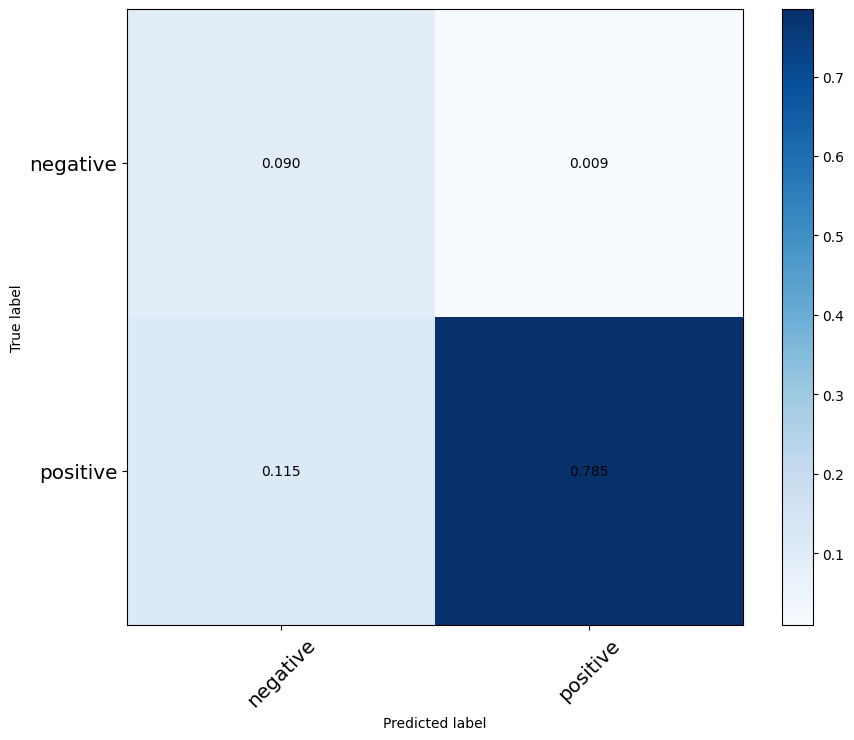

              precision    recall  f1-score   support

    negative       0.44      0.91      0.59     33022
    positive       0.99      0.87      0.93    298165

    accuracy                           0.88    331187
   macro avg       0.71      0.89      0.76    331187
weighted avg       0.93      0.88      0.89    331187



In [23]:
from fhnw.nlp.utils.ploting import report_classification_results

report_classification_results(params, data[params["y_column_name"]].to_list(), preds)

bert
nlptown/bert-base-multilingual-uncased-sentiment has a better performance (runtime ~54min)

              precision    recall  f1-score   support

    negative       0.76      0.87      0.81     33022
    positive       0.98      0.97      0.98    298168

    accuracy                           0.96    331190
    macro avg      0.87      0.92      0.89    331190
    weighted avg   0.96      0.96      0.96    331190
    
    

distilbert
philschmid/distilbert-base-multilingual-cased-sentiment-2 (runtime ~29min)

              precision    recall  f1-score   support

    negative       0.44      0.91      0.59     33022
    positive       0.99      0.87      0.93    298165

    accuracy                           0.88    331187
    macro avg      0.71      0.89      0.76    331187
    weighted avg   0.93      0.88      0.89    331187